In [1]:
import torch
import clip
from PIL import Image
import torchvision.transforms as transforms
import pickle as pkl
import joblib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import os
import faiss
import numpy as np
import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
device

'cuda'

In [5]:
model, preprocess = clip.load("ViT-B/32", device=device)

100%|███████████████████████████████████████| 338M/338M [04:20<00:00, 1.36MiB/s]


In [33]:
model, preprocess = clip.load("ViT-L/14", device=device)

In [3]:
source_a_path = "data/RawCitiesData/The Hague/Source B/source_b_boundaries.pkl"
source_b_path = "data/RawCitiesData/The Hague/Source A/source_a_boundaries.pkl"
object_dict_path = "data/RawCitiesData/The Hague/object_dict.pkl"

In [21]:
polygon_mesh_dict_a = joblib.load(source_a_path)

In [22]:
polygon_mesh_dict_b = joblib.load(source_b_path)

In [7]:
a = 'check'
print(a.replace('c', 'd'))
print(a)

dhedk
check


# Generate Images

In [36]:
def find_min_coord(dim, polygon_mesh):
    return min([vertex[dim] for surface in polygon_mesh for vertex in surface])

def find_max_coord(dim, polygon_mesh):
    return max([vertex[dim] for surface in polygon_mesh for vertex in surface])


def plot_object(obj_id, polygon_mesh, save_dir, margin=3):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Add polygon mesh
    for surface in polygon_mesh:
        poly = Poly3DCollection([surface], alpha=0.5, edgecolor='k')
        ax.add_collection3d(poly)

    # Set limits
    x_min = find_min_coord(0, polygon_mesh) - margin
    y_min = find_min_coord(1, polygon_mesh) - margin
    z_min = find_min_coord(2, polygon_mesh) - margin
    x_max = find_max_coord(0, polygon_mesh) + margin
    y_max = find_max_coord(1, polygon_mesh) + margin
    z_max = find_max_coord(2, polygon_mesh) + margin

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_zlim(z_min, z_max)

    # Remove axes
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_zlabel('')
    plt.savefig(os.path.join(save_dir, f'{obj_id}.png'), format='png', bbox_inches='tight', pad_inches=0, transparent=True)
    # plt.show()
    plt.close(fig)


In [43]:

source_a_keys = set(polygon_mesh_dict_a.keys())
source_b_keys = set(polygon_mesh_dict_b.keys())
intersection_keys = list(source_a_keys.intersection(source_b_keys))
# print(f"Source A keys: {len(source_a_keys)}")
# print(f"Source B keys: {len(source_b_keys)}")
print(f"Intersection keys: {len(intersection_keys)}")

Intersection keys: 17887


In [111]:
# figs_source_a = 'data/RawCitiesData/The Hague/Source A/png_figs'
# figs_source_b = 'data/RawCitiesData/The Hague/Source B/png_figs'
# figs_num_a = 2000
# figs_num_b = 200
# for obj_id in tqdm.tqdm(intersection_keys[:figs_num_a]):
#     plot_object(obj_id, polygon_mesh_dict_a[obj_id]['polygon_mesh'], figs_source_a)
#     
# for obj_id in tqdm.tqdm(intersection_keys[:figs_num_b]):
#     plot_object(obj_id, polygon_mesh_dict_b[obj_id]['polygon_mesh'], figs_source_b)

100%|██████████| 200/200 [00:23<00:00,  8.64it/s]


In [1]:
check = {}
print(check.keys())

dict_keys([])


# Read Data Partition

In [4]:
dataset_name = "Hague"
dataset_partition_dict = pkl.load(open(f"{dataset_name}_seed3.pkl", 'rb'))
figs_source_a = 'data/RawCitiesData/The Hague/Source A/png_figs'
figs_source_b = 'data/RawCitiesData/The Hague/Source B/png_figs'

In [8]:
for dsize in ['small', 'medium', 'large']:
    for neg_samples in [2, 5]:
        print(f"Number of pairs: {len(dataset_partition_dict['train'][dsize][neg_samples])} for neg_samples: {neg_samples} and dsize: {dsize}")
        print(f"Number of matching pairs: {len([pair for pair in dataset_partition_dict['train'][dsize][neg_samples] if pair[0] == pair[1]])}")
        print("===========================================")

Number of pairs: 6606 for neg_samples: 2 and dsize: small
Number of matching pairs: 2202
Number of pairs: 13212 for neg_samples: 5 and dsize: small
Number of matching pairs: 2202
Number of pairs: 26423 for neg_samples: 2 and dsize: medium
Number of matching pairs: 8808
Number of pairs: 52847 for neg_samples: 5 and dsize: medium
Number of matching pairs: 8808
Number of pairs: 39637 for neg_samples: 2 and dsize: large
Number of matching pairs: 13213
Number of pairs: 79275 for neg_samples: 5 and dsize: large
Number of matching pairs: 13213


In [9]:
for dsize in ['small', 'medium', 'large']:
    curr_dict = dataset_partition_dict['test']['matching']['negative_sampling']
    for neg_samples in [2, 5]:
        print(f"Number of pairs: {len(curr_dict[dsize][neg_samples])} for neg_samples: {neg_samples} and dsize: {dsize}")
        print(f"Number of matching pairs: {len([pair for pair in curr_dict[dsize][neg_samples] if pair[0] == pair[1]])}")
        print("===========================================")

Number of pairs: 5946 for neg_samples: 2 and dsize: small
Number of matching pairs: 1982
Number of pairs: 11892 for neg_samples: 5 and dsize: small
Number of matching pairs: 1982
Number of pairs: 19821 for neg_samples: 2 and dsize: medium
Number of matching pairs: 6607
Number of pairs: 39642 for neg_samples: 5 and dsize: medium
Number of matching pairs: 6607
Number of pairs: 26427 for neg_samples: 2 and dsize: large
Number of matching pairs: 8809
Number of pairs: 52853 for neg_samples: 5 and dsize: large
Number of matching pairs: 8809


In [44]:
for dsize in ['small', 'medium', 'large']:
    curr_dict = dataset_partition_dict['test']['blocking']
    for dsize in ['small', 'large']:
        print(f"Number of cands: {len(curr_dict[dsize]['cands'])} and number of index: {len(curr_dict[dsize]['index'])} for dsize: {dsize}")

Number of cands: 1982 and number of index: 5143 for dsize: small
Number of cands: 8809 and number of index: 33830 for dsize: large
Number of cands: 1982 and number of index: 5143 for dsize: small
Number of cands: 8809 and number of index: 33830 for dsize: large
Number of cands: 1982 and number of index: 5143 for dsize: small
Number of cands: 8809 and number of index: 33830 for dsize: large


In [20]:
cands_ids_test = dataset_partition_dict['test']['blocking']['small']['cands']
index_ids_test = dataset_partition_dict['test']['blocking']['small']['index']

# Generate embds

In [5]:
def get_clip_embedding(model, image_path):
    image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
    with torch.no_grad():
        embedding = model.encode_image(image).float()
    return embedding.cpu().numpy()

def get_all_source_embds(figs_dir, rel_ids, model):
    embds = []
    fig_names = os.listdir(figs_dir)
    figs_to_embed = [fig_name for fig_name in fig_names if fig_name.split('.')[0] in rel_ids]
    mapping_dict = {}
    for ind, fig_name in enumerate(tqdm.tqdm(figs_to_embed)):
        embds.append(get_clip_embedding(model, ''.join([figs_dir, '/', fig_name])))
        mapping_dict[ind] = fig_name.split('.')[0]
    embds = np.array(embds, dtype=np.float32)
    return np.squeeze(embds, axis=1), mapping_dict

In [60]:
model_name = "ViT-L/14" # options are: "ViT-B/32" and "ViT-L/14"
model_embds_dict = {}
for model_name in ["ViT-B/32", "ViT-L/14"]:
    model_embds_dict[model_name] = {}
    model = clip.load(model_name, device=device)[0]
    source_a_embds, mapping_dict_a = get_all_source_embds(figs_source_a, cands_ids_test, model)
    source_b_embds, mapping_dict_b = get_all_source_embds(figs_source_b, index_ids_test, model)
    model_embds_dict[model_name]['cands'] = source_a_embds
    model_embds_dict[model_name]['index'] = source_b_embds
model_embds_dict['mapping_dict_cands'] = mapping_dict_a
model_embds_dict['mapping_dict_index'] = mapping_dict_b

  2%|▏         | 33/1982 [00:01<01:25, 22.73it/s]


KeyboardInterrupt: 

In [41]:
model_embds_dict["ViT-L/14"] = {'cands': source_a_embds, 'index': source_b_embds}

In [35]:
# model_embds_dict = {}
# model_embds_dict["ViT-B/32"] = {'cands': source_a_embds, 'index': source_b_embds}

In [18]:
len(source_a_embds), len(source_b_embds)

(1982, 5143)

In [39]:
len(mapping_dict_a), len(mapping_dict_b)

(1982, 5143)

In [107]:
del source_a_embds
del source_b_embds

# VIT Search

In [23]:
for elem in mapping_dict_a.values():
    if elem not in mapping_dict_b.values():
        print(elem)

In [56]:
k = 50
retrieval_dict = {}
for model_name, embds_dicts in model_embds_dict.items():
    retrieval_dict[model_name] = {}
    index = faiss.IndexFlatL2(embds_dicts['index'].shape[1])
    index.add(embds_dicts['index'])
    for i, query in enumerate(embds_dicts['cands']):
        _, neighbors = index.search(query.reshape(1, -1), k)
        retrieval_dict[model_name][mapping_dict_a[i]] = [mapping_dict_b[ind] for ind in neighbors[0]]

# Evaluation

In [57]:
recall_dict = {model_name: {} for model_name in retrieval_dict.keys()}
for model_name, retrieval in retrieval_dict.items():
    for k_local in range(1, k + 1):
        recall_dict[model_name][k_local] = round(np.mean([1 if key in value[:k_local] else 0 for key, value in retrieval_dict[model_name].items()]), 6)

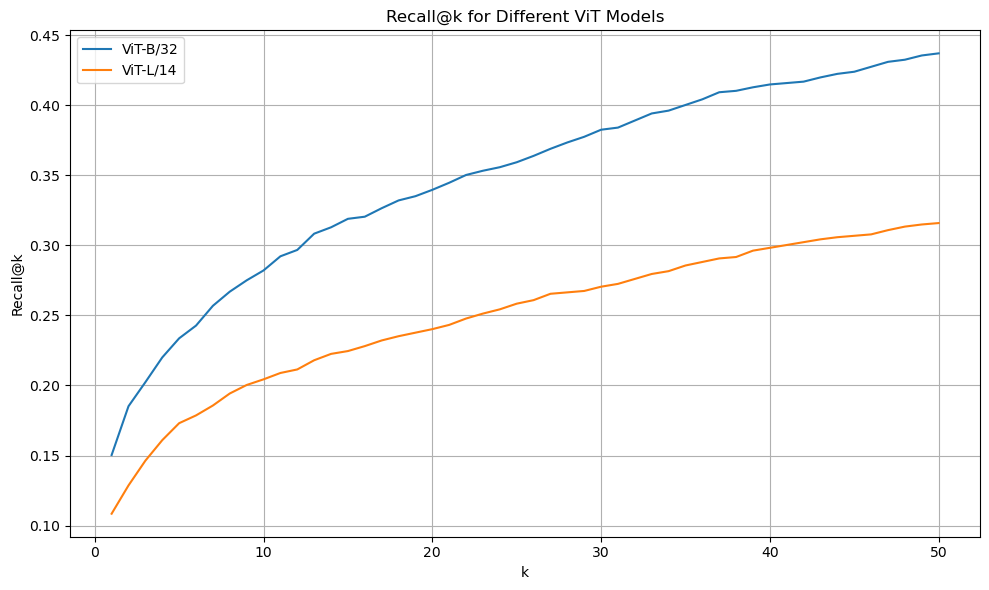

In [61]:
plt.figure(figsize=(10,6))
for model_name, recall in recall_dict.items():
    plt.plot(list(recall.keys()), list(recall.values()), label=model_name)
plt.xlabel("k")
plt.ylabel("Recall@k")
plt.title("Recall@k for Different ViT Models")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


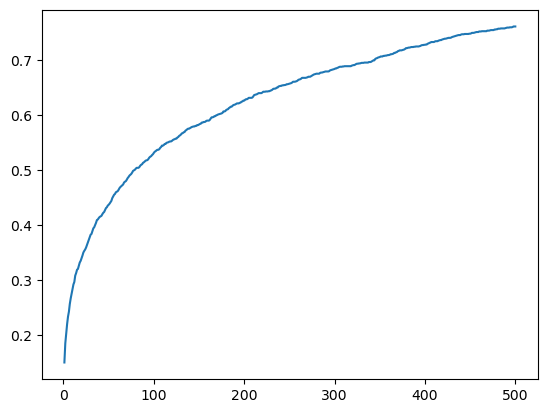

In [32]:
plt.plot(list(recall_dict.keys()), list(recall_dict.values()))

# With contrastive loss

In [6]:
training_pairs = dataset_partition_dict['train']['small'][2]

In [7]:
print(f"Number of pairs: {len(training_pairs)}")
print(f"Number of matching pairs: {len([pair for pair in training_pairs if pair[0] == pair[1]])}")
print(f"Number of non-matching pairs: {len([pair for pair in training_pairs if pair[0] != pair[1]])}")

Number of pairs: 6606
Number of matching pairs: 2202
Number of non-matching pairs: 4404


In [8]:
# 1. Dataset for (img1, img2, label) pairs
class ContrastivePairDataset(Dataset):
    def __init__(self, training_pairs, transform):
        self.pairs = training_pairs
        self.transform = transform

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        cand_path, index_path = self.pairs[idx]
        cand_id = os.path.splitext(os.path.basename(cand_path))[0]
        index_id = os.path.splitext(os.path.basename(index_path))[0]
        label = 1 if cand_id == index_id else -1  # CosineEmbeddingLoss expects ±1
        cand_img = self.transform(Image.open(cand_path).convert("RGB"))
        index_img = self.transform(Image.open(index_path).convert("RGB"))
        return cand_img, index_img, torch.tensor(label, dtype=torch.float32)

In [9]:
model_name = "ViT-B/32" # options are: "ViT-B/32" and "ViT-L/14"
model, preprocess = clip.load(model_name, device=device)
vision_encoder = model.visual

In [23]:

class ContrastiveModel(nn.Module):
    def __init__(self, encoder):
        super().__init__()
        self.encoder = encoder

    def forward(self, img1, img2):
        emb1 = self.encoder(img1)
        emb2 = self.encoder(img2)
        return emb1, emb2

In [24]:
contrastive_model = ContrastiveModel(vision_encoder).to(device).float()
loss_fn = nn.CosineEmbeddingLoss()
optimizer = torch.optim.AdamW(contrastive_model.parameters(), lr=1e-5)

In [25]:
def get_training_pairs_paths(training_pairs):
    training_pair_paths = []
    for pair in training_pairs:
        training_pair_paths.append((''.join((figs_source_a, f"/{pair[0]}.png")), 
                                    ''.join((figs_source_b, f"/{pair[1]}.png"))))
    return training_pair_paths

In [26]:
def get_clip_embedding(model, image_path):
    image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
    with torch.no_grad():
        embedding = model.encode_image(image).float()
    return embedding.cpu().numpy()

def get_all_source_embds(figs_dir, rel_ids, model):
    embds = []
    fig_names = os.listdir(figs_dir)
    figs_to_embed = [fig_name for fig_name in fig_names if fig_name.split('.')[0] in rel_ids]
    mapping_dict = {}
    for ind, fig_name in enumerate(tqdm.tqdm(figs_to_embed)):
        embds.append(get_clip_embedding(model, ''.join([figs_dir, '/', fig_name])))
        mapping_dict[ind] = fig_name.split('.')[0]
    embds = np.array(embds, dtype=np.float32)
    return np.squeeze(embds, axis=1), mapping_dict

In [27]:
training_pair_paths = get_training_pairs_paths(training_pairs)

In [28]:
dataset = ContrastivePairDataset(training_pair_paths, transform=preprocess)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

In [98]:
epochs = 5
contrastive_model.train()
for epoch in range(epochs):
    total_loss = 0
    for img1, img2, label in tqdm.tqdm(dataloader):
        img1, img2, label = img1.to(device), img2.to(device), label.to(device)
        emb1, emb2 = contrastive_model(img1, img2)
        loss = loss_fn(emb1, emb2, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss:.4f}")

# 7. Save the encoder
torch.save(contrastive_model.state_dict(), "finetuned_vit_clip.pth")


 12%|█▏        | 197/1652 [00:27<03:21,  7.23it/s]


KeyboardInterrupt: 

# Use fine-tuned model

In [29]:
# Wrap it in your ContrastiveModel class
class ContrastiveModelEncoder(torch.nn.Module):
    def __init__(self, encoder):
        super().__init__()
        self.encoder = encoder

    def forward(self, x):
        return self.encoder(x)

In [30]:
clip_model, preprocess = clip.load(model_name, device=device)
vision_encoder = clip_model.visual

In [31]:
model = ContrastiveModelEncoder(vision_encoder).to(device)
model.load_state_dict(torch.load("finetuned_vit_clip.pth", map_location=device))
model.eval()

ContrastiveModelEncoder(
  (encoder): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, b

In [32]:
@torch.no_grad()
def get_embedding_finetuned(model, image_path):
    image = preprocess(Image.open(image_path).convert("RGB")).unsqueeze(0).to(device).half()
    embedding = model(image)  # single-image forward
    return embedding.cpu().numpy().astype(np.float32).squeeze()


In [33]:
def get_all_source_finetuned_embds(figs_dir, rel_ids, model):
    embds = []
    fig_names = os.listdir(figs_dir)
    figs_to_embed = [fig_name for fig_name in fig_names if fig_name.split('.')[0] in rel_ids]
    mapping_dict = {}
    for ind, fig_name in enumerate(tqdm.tqdm(figs_to_embed)):
        embds.append(get_embedding_finetuned(model, ''.join([figs_dir, '/', fig_name])))
        mapping_dict[ind] = fig_name.split('.')[0]
    embds = np.array(embds, dtype=np.float32)
    return embds, mapping_dict

In [38]:
embds_dict = {}
cands_embds, mapping_dict_cands = get_all_source_finetuned_embds(figs_source_a, cands_ids_test, model)
index_embds, mapping_dict_index = get_all_source_finetuned_embds(figs_source_b, index_ids_test, model)
embds_dict['cands'] = cands_embds
embds_dict['index'] = index_embds
# model_embds_dict['mapping_dict_cands'] = mapping_dict_cands
# model_embds_dict['mapping_dict_index'] = mapping_dict_cands

100%|██████████| 5143/5143 [01:26<00:00, 59.54it/s]


In [40]:
k = 50
retrieval_dict = {}
index = faiss.IndexFlatL2(embds_dict['index'].shape[1])
index.add(embds_dict['index'])
for i, query in enumerate(embds_dict['cands']):
    _, neighbors = index.search(query.reshape(1, -1), k)
    retrieval_dict[mapping_dict_cands[i]] = [mapping_dict_index[ind] for ind in neighbors[0]]

In [41]:
recall_dict = {}
for k_local in range(1, k + 1):
    recall_dict[k_local] = round(np.mean([1 if key in value[:k_local] else 0 for key, value in retrieval_dict.items()]), 6)

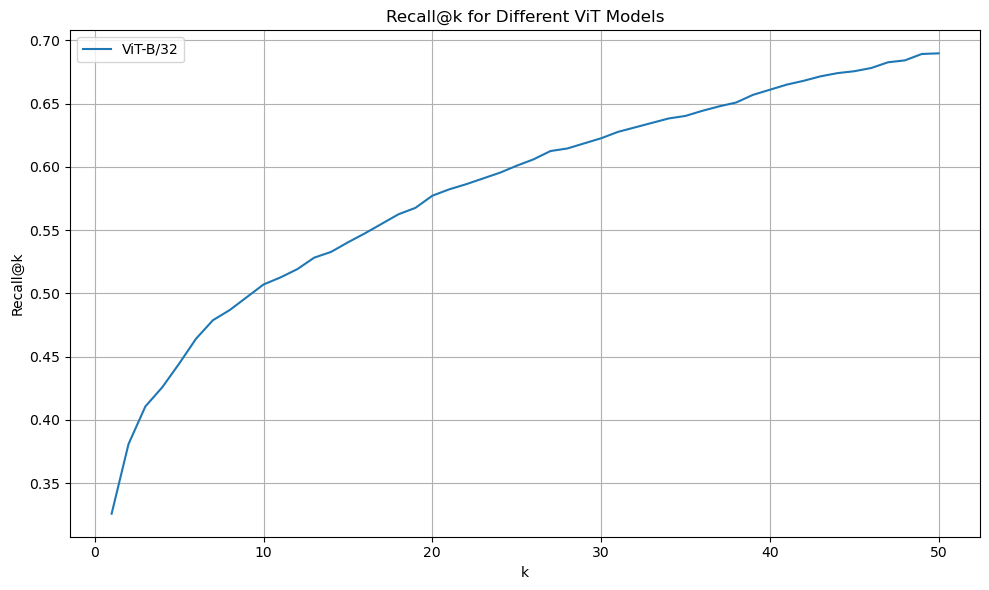

In [43]:
plt.figure(figsize=(10,6))
plt.plot(list(recall_dict.keys()), list(recall_dict.values()), label=model_name)
plt.xlabel("k")
plt.ylabel("Recall@k")
plt.title("Recall@k for Different ViT Models")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
